# Using `load_ard` to load and cloud mask multiple satellite sensors

### Description
This notebook demonstrates how to use the `load_ard` function to import a time series of cloud-free observations over Africa from multiple Landsat satellites (i.e. Landsat 5, 7 and 8).
The function automatically applies cloud masking to the input data and returns all available data from multiple sensors as a single combined `xarray.Dataset`.

Optionally, the function can be used to return only observations that contain a minimum proportion of good quality non-cloudy or shadowed pixels.
This can be used to extract visually appealing time series of observations that are not affected by cloud.

The `load_ard` function is technically compatible with both USGS Collection 1 and Collection 2 data, however only USGS Collection 1 data is currently available to load via Digital Earth Africa. `load_ard` can also load Sentinel 2 data.


This notebook demonstrates how to use `load_ard` to
* Load and combine Landsat 5, 7 and 8 data into a single `xarray.Dataset`
* Optionally apply a cloud mask to the resulting data
* Filter resulting data to keep only cloud-free observations
* Load and combine Sentinel 2a and 2b data into a single `xarray.Dataset`
* Lazily load data using Dask

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import datacube.utils.rio
import sys

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import rgb


### Connect to the datacube


In [2]:
# Connect to datacube 
dc = datacube.Datacube(app='Using_load_ard')

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)


## Loading multiple Landsat sensors
The `load_ard` function can be used to load a single, combined timeseries of cloud-masked data from multiple Landsat satellites. 
At its simplest, you can use the function similarly to `dc.load` by passing a set of spatiotemporal query parameters (e.g. `x`, `y`, `time`, `measurements`, `output_crs`, `resolution`, `group_by` etc) directly into the function ([see the `dc.load` documentation for all possible options](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)). 
The key difference from `dc.load` is that the function also requires an existing `Datacube` object, which is passed using the `dc` parameter. 
This gives us the flexibilty to load data from development or experimental datacubes.

In the examples below, we load three bands of data (`red`, `green`, `blue`) from the three USGS Collection 1 products (Landsat 5, 7 and 8) by specifying:

`products=['ls5_usgs_sr_scene', 'ls7_usgs_sr_scene', 'ls8_usgs_sr_scene']`

The function always outputs the number of observations for each product, and the total number loaded.

### Explicit syntax
The following example demonstrates how key parameters can be passed directly to `load_ard`.

In [3]:
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc,
                            product='ls8_usgs_sr_scene',
                            query={'x': (-1.9, -2), 'y': (6.9,7)})

In [4]:
ds = load_ard(dc=dc,
              products=['ls5_usgs_sr_scene',
                        'ls7_usgs_sr_scene', 
                        'ls8_usgs_sr_scene'], 
              x=(-1.9, -2),
              y=(6.9, 7),
              time=('2017-01', '2017-04'),
              measurements = ['red', 'green', 'blue'],
              output_crs=output_crs,
              align=(15, 15),
              resolution=(-30, 30),
              group_by='solar_day')

# Print output data
print(ds)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls5_usgs_sr_scene
    ls7_usgs_sr_scene
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Loading 25 time steps
<xarray.Dataset>
Dimensions:  (time: 25, x: 370, y: 370)
Coordinates:
  * y        (y) float64 7.739e+05 7.738e+05 7.738e+05 ... 7.628e+05 7.628e+05
  * x        (x) float64 6.105e+05 6.105e+05 6.105e+05 ... 6.215e+05 6.215e+05
  * time     (time) datetime64[ns] 2017-01-07T10:27:51.185930 ... 2017-04-30T10:23:55.082457
Data variables:
    red      (time, y, x) float32 570.0 547.0 547.0 536.0 ... nan nan nan nan
    green    (time, y, x) float32 639.0 630.0 632.0 616.0 ... nan nan nan nan
    blue     (time, y, x) float32 294.0 289.0 279.0 260.0 ... nan nan nan nan
Attributes:
    crs:      epsg:32630


### Query syntax
The following example demonstrates how key parameters can be stored in a `query` dictionary, to be passed as a single parameter to `load_ard`.
The `query` can then be reused in other `load_ard` calls.

In [5]:
# Create a reusable query
query = {
    'x': (-1.9, -2),
    'y': (6.9,7),
    'time': ('2017-01', '2017-04'),
    'measurements': ['red', 'green', 'blue'],
    'group_by': 'solar_day'
}

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc, 
              products=['ls5_usgs_sr_scene', 
                        'ls7_usgs_sr_scene', 
                        'ls8_usgs_sr_scene'], 
              output_crs=output_crs,
              align=(15, 15),
              resolution=(-30, 30),
              **query)

# Print output data
print(ds)


Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls5_usgs_sr_scene
    ls7_usgs_sr_scene
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Loading 25 time steps
<xarray.Dataset>
Dimensions:  (time: 25, x: 370, y: 370)
Coordinates:
  * y        (y) float64 7.739e+05 7.738e+05 7.738e+05 ... 7.628e+05 7.628e+05
  * x        (x) float64 6.105e+05 6.105e+05 6.105e+05 ... 6.215e+05 6.215e+05
  * time     (time) datetime64[ns] 2017-01-07T10:27:51.185930 ... 2017-04-30T10:23:55.082457
Data variables:
    red      (time, y, x) float32 570.0 547.0 547.0 536.0 ... nan nan nan nan
    green    (time, y, x) float32 639.0 630.0 632.0 616.0 ... nan nan nan nan
    blue     (time, y, x) float32 294.0 289.0 279.0 260.0 ... nan nan nan nan
Attributes:
    crs:      epsg:32630


### Working with cloud masking
By plotting a time slice from the data we loaded above, you can see an area of white pixels where clouds have been masked out and set to `NaN`:

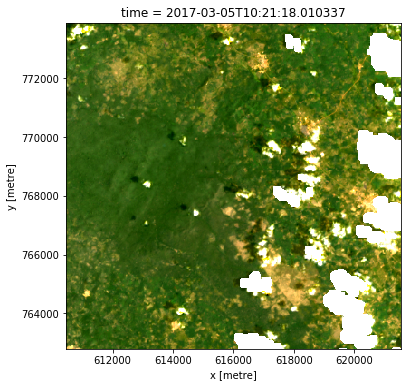

In [6]:
# Plot single observation
rgb(ds, index=13)


By default, `load_ard` applies a pixel quality mask to loaded data using the sensor's pixel quality band. For USGS Collection 1, this masks out clouds, cloud shadow and nodata by default using the following mask parameters that are applied to the `pixel_qa` band:

```
{'cloud': 'no_cloud', 
 'cloud_shadow': 'no_cloud_shadow', 
 'nodata': False}
```

For USGS Collection 2 *(currently not available)*, the following mask parameters are applied to the `quality_l2_aerosol` band: 

```
{'cloud_shadow': 'not_cloud_shadow', 
'cloud_or_cirrus': 'not_cloud_or_cirrus', 
'nodata': False}
```

For Sentinel 2, the following mask parameters are applied to the `scl` band: 

```
['vegetation','snow or ice','water', 'bare soils','unclassified']
```

> **Note:** These masking parameters can be customised using the `pq_categories_ls` parameter for USGS data, and the `pq_categories_s2` parameter for Sentinel 2 data

We can de-activate pixel masking completely by setting `mask_pixel_quality=False`:




Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls5_usgs_sr_scene
    ls7_usgs_sr_scene
    ls8_usgs_sr_scene
Loading 25 time steps


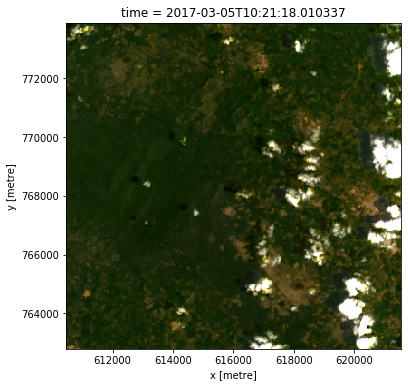

In [7]:
# Load available data with cloud masking deactivated
ds = load_ard(dc=dc, 
              products=['ls5_usgs_sr_scene', 
                        'ls7_usgs_sr_scene', 
                        'ls8_usgs_sr_scene'], 
              mask_pixel_quality=False, 
              output_crs=output_crs,
              align=(15, 15),
              resolution=(-30, 30),
              **query)

# Plot single observation
rgb(ds, index=13)


### Filtering to non-cloudy observations
In addition to masking out cloud, `load_ard` allows you to discard any satellite observation that contains less than a minimum proportion of good quality (e.g. non-cloudy) pixels.
This can be used to obtain a time series of only clear, cloud-free observations.

To discard all observations with less than `X`% good quality pixels, use the `min_gooddata` parameter. 
For example, `min_gooddata=0.90` will return only observations where less than 10 % of pixels contain cloud, cloud shadow or other invalid data, resulting in a smaller number of clear, cloud free images being returned by the function:

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls5_usgs_sr_scene
    ls7_usgs_sr_scene
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Counting good quality pixels for each time step
Filtering to 1 out of 25 time steps with at least 90.0% good quality pixels
Loading 1 time steps


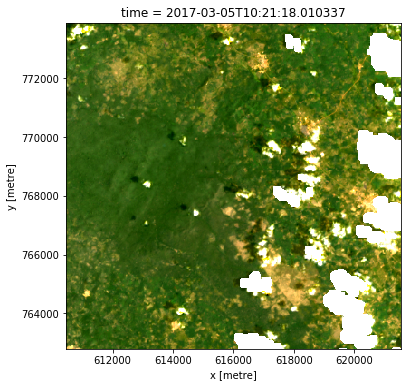

In [8]:
# Load available data filtered to 99% clear observations
ds = load_ard(dc=dc, 
              products=['ls5_usgs_sr_scene', 
                        'ls7_usgs_sr_scene', 
                        'ls8_usgs_sr_scene'], 
              min_gooddata=0.90, 
              output_crs=output_crs,
              align=(15, 15),
              resolution=(-30, 30),
              **query)

# Plot single observation
rgb(ds, index=0)


## Loading Sentinel-2 data
Data from the Sentinel-2A and Sentinel-2B satellites can also be loaded using `load_ard`. To do this, we need to specify the two Sentinel-2 products (['s2a_msil2a', 's2b_msil2a']) in place of the Landsat products above. The query parameter can be reused to load Sentinel-2 data for the same specifcations used for the Landsat data above:

In [9]:
# Load available data from both S2 datasets
s2 = load_ard(dc=dc,
              products=['s2a_msil2a', 
                        's2b_msil2a'], 
              output_crs=output_crs,
              resolution=(-10, 10),
              **query)

# Print output data
print(s2)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2a_msil2a
    s2b_msil2a
Applying pixel quality/cloud mask
Loading 7 time steps
<xarray.Dataset>
Dimensions:  (time: 7, x: 1108, y: 1109)
Coordinates:
  * y        (y) float64 7.739e+05 7.739e+05 7.739e+05 ... 7.628e+05 7.628e+05
  * x        (x) float64 6.105e+05 6.105e+05 6.105e+05 ... 6.215e+05 6.215e+05
  * time     (time) datetime64[ns] 2017-02-26T10:37:18.460000 ... 2017-04-27T10:29:59.096000
Data variables:
    red      (time, y, x) float32 nan nan nan nan ... 727.0 763.0 807.0 838.0
    green    (time, y, x) float32 nan nan nan nan ... 976.0 999.0 1024.0 1048.0
    blue     (time, y, x) float32 nan nan nan nan ... 579.0 572.0 623.0 673.0
Attributes:
    crs:      epsg:32630


Cloudy pixels are masked out by default from the resulting observations similarly to Landsat:

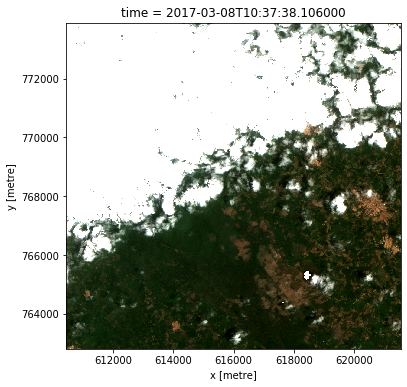

In [10]:
# Plot single observation
rgb(s2, index=1)

## Lazy loading with Dask
Rather than load data directly - which can take a long time and large amounts of memory - all datacube data can be lazy loaded using Dask. This can be a very useful approach for when you need to load large amounts of data without crashing your analysis, or if you want to subsequently scale your analysis by distributing tasks in parallel across multiple workers.

The load_ard function can be easily adapted to lazily load data rather than loading it into memory by providing a dask_chunks parameter using either the explicit or query syntax. The minimum required to lazily load data is dask_chunks={}, but chunking can also be performed spatially (e.g. dask_chunks={'x': 1000, 'y': 1000}) or by time (e.g. dask_chunks={'time': 1}) depending on the analysis being conducted.

In [11]:
# Load available data from both S2 datasets
s2 = load_ard(dc=dc,
              products=['s2a_msil2a', 
                        's2b_msil2a'], 
              output_crs=output_crs,
              resolution=(-10, 10),
              dask_chunks={},
              **query)

# Print output data
print(s2)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2a_msil2a
    s2b_msil2a
Applying pixel quality/cloud mask
Returning 7 time steps as a dask array
<xarray.Dataset>
Dimensions:  (time: 7, x: 1108, y: 1109)
Coordinates:
  * y        (y) float64 7.739e+05 7.739e+05 7.739e+05 ... 7.628e+05 7.628e+05
  * x        (x) float64 6.105e+05 6.105e+05 6.105e+05 ... 6.215e+05 6.215e+05
  * time     (time) datetime64[ns] 2017-02-26T10:37:18.460000 ... 2017-04-27T10:29:59.096000
Data variables:
    red      (time, y, x) float32 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    green    (time, y, x) float32 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    blue     (time, y, x) float32 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
Attributes:
    crs:      epsg:32630


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Feb 2020

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.7+253.ga031f3f4.dirty
